# Análisis de VaR con Ventanas Rolling de 1000 Días

Este notebook calcula el Value at Risk (VaR) utilizando ventanas móviles de 1000 días históricos, calculando tanto VaR Paramétrico como No Paramétrico para niveles de confianza del 95% y 99%.

## Portafolio
- **NVDA.O** (NVIDIA)
- **AAPL.O** (Apple)
- **LMT** (Lockheed Martin)
- **MSFT.O** (Microsoft)
- **SIEGn.DE Usd** (Siemens en USD)
- **GOOGL.O** (Google/Alphabet)
- **INTC.O** (Intel)

## 1. Importar Librerías y Configuración

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 10

print("✓ Librerías importadas correctamente")

✓ Librerías importadas correctamente


## 2. Cargar y Preparar Datos

In [34]:
# Cargar datos históricos
df = pd.read_csv('precios_historicos.csv')

# Convertir la columna Date a datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha de más antigua a más reciente para facilitar el análisis
df = df.sort_values('Date').reset_index(drop=True)

# Seleccionar solo las columnas de precios (excluir EUR= ya que SIEGn.DE Usd ya está en dólares)
columnas_precios = ['NVDA.O', 'AAPL.O', 'LMT', 'MSFT.O', 'SIEGn.DE Usd', 'GOOGL.O', 'INTC.O']

print("="*70)
print("DATOS CARGADOS")
print("="*70)
print(f"Total de registros: {len(df)}")
print(f"Rango de fechas: {df['Date'].min().strftime('%d/%m/%Y')} a {df['Date'].max().strftime('%d/%m/%Y')}")
print(f"\nColumnas de precios utilizadas:")
for col in columnas_precios:
    print(f"  • {col}")
print("\nPrimeras filas:")
print(df[['Date'] + columnas_precios].head())
print("\nÚltimas filas:")
print(df[['Date'] + columnas_precios].tail())

DATOS CARGADOS
Total de registros: 1056
Rango de fechas: 23/08/2021 a 25/11/2025

Columnas de precios utilizadas:
  • NVDA.O
  • AAPL.O
  • LMT
  • MSFT.O
  • SIEGn.DE Usd
  • GOOGL.O
  • INTC.O

Primeras filas:
        Date  NVDA.O  AAPL.O     LMT  MSFT.O  SIEGn.DE Usd  GOOGL.O  INTC.O
0 2021-08-23   21.96  149.71  357.35  304.65           NaN   140.04   53.23
1 2021-08-24   21.79  149.62  359.00  302.62           NaN   141.26   53.81
2 2021-08-25   22.21  148.36  358.75  302.01           NaN   142.08   53.81
3 2021-08-26   22.07  147.54  361.62  299.09           NaN   141.44   53.13
4 2021-08-27   22.64  148.60  361.99  299.72           NaN   144.00   53.89

Últimas filas:
           Date  NVDA.O  AAPL.O     LMT  MSFT.O  SIEGn.DE Usd  GOOGL.O  INTC.O
1051 2025-11-19  186.52  268.56  469.91  487.12    252.176960   292.81   35.11
1052 2025-11-20  180.64  266.25  468.26  478.43    254.861970   289.45   33.62
1053 2025-11-21  178.88  271.49  460.78  472.12    252.263565   299.66   34.50


## 3. Definir Pesos del Portafolio

Definimos el número de acciones de cada empresa en el portafolio. Esto nos permitirá calcular el valor total del portafolio (V0) en cada día.

In [35]:
# Definir el número de acciones de cada empresa en el portafolio
# (Puedes ajustar estos valores según tu portafolio real)
acciones = {
    'NVDA.O': 1892,
    'AAPL.O': 528,
    'LMT': 217,
    'MSFT.O': 200,
    'SIEGn.DE Usd': 369,
    'GOOGL.O': 381,
    'INTC.O': 1436
}

print("Composición del Portafolio:")
print("="*50)
for empresa, num_acciones in acciones.items():
    print(f"  {empresa:15s}: {num_acciones:5d} acciones")
print("="*50)

Composición del Portafolio:
  NVDA.O         :  1892 acciones
  AAPL.O         :   528 acciones
  LMT            :   217 acciones
  MSFT.O         :   200 acciones
  SIEGn.DE Usd   :   369 acciones
  GOOGL.O        :   381 acciones
  INTC.O         :  1436 acciones


## 4. Función para Calcular VaR en Ventana de 1000 Días

Esta función calcula el VaR Paramétrico y No Paramétrico para una ventana específica de 1000 días.

In [36]:
def calcular_var_ventana(df_ventana, acciones, columnas_precios):
    """
    Calcula VaR Paramétrico y No Paramétrico para una ventana de datos.
    
    Parameters:
    -----------
    df_ventana : DataFrame
        Ventana de 1000 días de datos
    acciones : dict
        Diccionario con número de acciones por empresa
    columnas_precios : list
        Lista de columnas con precios
        
    Returns:
    --------
    dict con todos los resultados del VaR
    """
    # Calcular V0 (valor del portafolio) para cada día
    df_ventana = df_ventana.copy()
    df_ventana['V0'] = 0
    for empresa, num_acciones in acciones.items():
        df_ventana['V0'] += df_ventana[empresa] * num_acciones
    
    # Calcular P&L (cambio día a día en el valor del portafolio)
    df_ventana['P&L'] = df_ventana['V0'].diff()
    
    # Calcular Rendimientos
    df_ventana['Rendimiento'] = df_ventana['V0'].pct_change()
    
    # Limpiar NaN
    rendimientos = df_ventana['Rendimiento'].dropna()
    pnl = df_ventana['P&L'].dropna()
    
    # V0 actual (último día de la ventana)
    V0_actual = df_ventana['V0'].iloc[-1]
    
    # Estadísticas de rendimientos
    media_rendimiento = rendimientos.mean()
    std_rendimiento = rendimientos.std()
    
    # Valores z para niveles de confianza
    z_95 = 1.645  # 95% confianza (5% VaR)
    z_99 = 2.326  # 99% confianza (1% VaR)
    
    # ========== VaR PARAMÉTRICO ==========
    # Fórmula: VaR = V0 * (media - z * std)
    var_parametrico_95 = V0_actual * (z_95 * std_rendimiento - media_rendimiento)
    var_parametrico_99 = V0_actual * (z_99 * std_rendimiento - media_rendimiento)
    
    # ========== VaR NO PARAMÉTRICO (HISTÓRICO) ==========
    # Usar percentiles del P&L histórico
    pnl_sorted = pnl.sort_values()
    indice_5pct = int(len(pnl_sorted) * 0.05)
    indice_1pct = int(len(pnl_sorted) * 0.01)
    
    var_no_parametrico_95 = pnl_sorted.iloc[indice_5pct]
    var_no_parametrico_99 = pnl_sorted.iloc[indice_1pct]
    
    # Resultados
    resultados = {
        'fecha_inicio': df_ventana['Date'].iloc[0],
        'fecha_fin': df_ventana['Date'].iloc[-1],
        'V0': V0_actual,
        'media_rendimiento': media_rendimiento,
        'std_rendimiento': std_rendimiento,
        
        # VaR Paramétrico 95%
        'var_param_95_usd': var_parametrico_95,
        'var_param_95_pct': (var_parametrico_95 / V0_actual) * 100,
        
        # VaR Paramétrico 99%
        'var_param_99_usd': var_parametrico_99,
        'var_param_99_pct': (var_parametrico_99 / V0_actual) * 100,
        
        # VaR No Paramétrico 95%
        'var_noparam_95_usd': var_no_parametrico_95,
        'var_noparam_95_pct': (var_no_parametrico_95 / V0_actual) * 100,
        
        # VaR No Paramétrico 99%
        'var_noparam_99_usd': var_no_parametrico_99,
        'var_noparam_99_pct': (var_no_parametrico_99 / V0_actual) * 100,
    }
    
    return resultados

print("✓ Función calcular_var_ventana() definida")

✓ Función calcular_var_ventana() definida


## 5. Calcular VaR con Ventanas Rolling de 1000 Días

Ahora calcularemos el VaR para cada ventana de 1000 días, comenzando desde 23/8/2021 hasta 8/9/2025, y luego avanzando día por día hasta la fecha más reciente disponible.

In [37]:
# Definir la fecha de inicio para la primera ventana
fecha_inicio_primera_ventana = pd.to_datetime('2021-08-23')
fecha_fin_primera_ventana = pd.to_datetime('2025-09-08')

# Verificar que tenemos suficientes datos
print("Verificando disponibilidad de datos...")
print(f"Fecha de inicio solicitada: {fecha_inicio_primera_ventana.strftime('%d/%m/%Y')}")
print(f"Fecha de fin solicitada: {fecha_fin_primera_ventana.strftime('%d/%m/%Y')}")
print(f"Fecha más antigua en datos: {df['Date'].min().strftime('%d/%m/%Y')}")
print(f"Fecha más reciente en datos: {df['Date'].max().strftime('%d/%m/%Y')}")

# Encontrar el índice donde comienza la primera ventana
idx_inicio = df[df['Date'] >= fecha_inicio_primera_ventana].index[0]
print(f"\nÍndice de inicio: {idx_inicio}")
print(f"Total de registros disponibles desde el inicio: {len(df) - idx_inicio}")

# Calcular cuántas ventanas de 1000 días podemos hacer
ventana_size = 1000
num_ventanas = len(df) - idx_inicio - ventana_size + 1

print(f"\nNúmero de ventanas de {ventana_size} días que se calcularán: {num_ventanas}")
print(f"Primera ventana: registros {idx_inicio} a {idx_inicio + ventana_size - 1}")
print(f"Última ventana: registros {len(df) - ventana_size} a {len(df) - 1}")

Verificando disponibilidad de datos...
Fecha de inicio solicitada: 23/08/2021
Fecha de fin solicitada: 08/09/2025
Fecha más antigua en datos: 23/08/2021
Fecha más reciente en datos: 25/11/2025

Índice de inicio: 0
Total de registros disponibles desde el inicio: 1056

Número de ventanas de 1000 días que se calcularán: 57
Primera ventana: registros 0 a 999
Última ventana: registros 56 a 1055


In [38]:
# Calcular VaR para todas las ventanas rolling
resultados_list = []

print(f"\nCalculando VaR para {num_ventanas} ventanas...")
print("="*70)

for i in range(num_ventanas):
    # Definir índices de la ventana
    inicio = idx_inicio + i
    fin = inicio + ventana_size
    
    # Extraer ventana de datos
    df_ventana = df.iloc[inicio:fin].copy()
    
    # Calcular VaR para esta ventana
    resultado = calcular_var_ventana(df_ventana, acciones, columnas_precios)
    resultados_list.append(resultado)
    
    # Mostrar progreso cada 10 ventanas
    if (i + 1) % 10 == 0 or (i + 1) == num_ventanas:
        print(f"  Procesadas {i + 1}/{num_ventanas} ventanas... "
              f"Última fecha: {resultado['fecha_fin'].strftime('%d/%m/%Y')}")

print("="*70)
print("✓ Cálculos completados")

# Crear DataFrame con todos los resultados
df_resultados = pd.DataFrame(resultados_list)

print(f"\nTotal de ventanas calculadas: {len(df_resultados)}")
print(f"Rango de fechas finales: {df_resultados['fecha_fin'].min().strftime('%d/%m/%Y')} "
      f"a {df_resultados['fecha_fin'].max().strftime('%d/%m/%Y')}")


Calculando VaR para 57 ventanas...
  Procesadas 10/57 ventanas... Última fecha: 19/09/2025
  Procesadas 20/57 ventanas... Última fecha: 03/10/2025
  Procesadas 30/57 ventanas... Última fecha: 17/10/2025
  Procesadas 40/57 ventanas... Última fecha: 31/10/2025
  Procesadas 50/57 ventanas... Última fecha: 14/11/2025
  Procesadas 57/57 ventanas... Última fecha: 25/11/2025
✓ Cálculos completados

Total de ventanas calculadas: 57
Rango de fechas finales: 08/09/2025 a 25/11/2025


In [39]:
df_resultados

,fecha_inicio,fecha_fin,V0,media_rendimiento,std_rendimiento,var_param_95_usd,var_param_95_pct,var_param_99_usd,var_param_99_pct,var_noparam_95_usd,var_noparam_95_pct,var_noparam_99_usd,var_noparam_99_pct
0,2021-08-23,2025-09-08,8.677388e+05,0.000836,0.014732,20302.888465,2.339747,29008.207835,3.342966,-12080.560644,-1.392189,-22518.51058,-2.595080
1,2021-08-24,2025-09-09,8.707745e+05,0.000839,0.014724,20361.004696,2.338264,29092.422155,3.340982,-12080.560644,-1.387335,-22518.51058,-2.586032
2,2021-08-25,2025-09-10,8.812289e+05,0.000850,0.014721,20590.655684,2.336584,29424.965509,3.339083,-12080.560644,-1.370877,-22518.51058,-2.555353
3,2021-08-26,2025-09-11,8.850995e+05,0.000854,0.014714,20667.482930,2.335046,29536.294005,3.337059,-12080.560644,-1.364882,-22518.51058,-2.544178
4,2021-08-27,2025-09-12,8.895525e+05,0.000858,0.014707,20757.472963,2.333474,29666.691661,3.335013,-12080.560644,-1.358049,-22518.51058,-2.531442
5,2021-08-30,2025-09-15,8.983749e+05,0.000867,0.014702,20948.063528,2.331773,29942.773049,3.332993,-12080.560644,-1.344713,-22518.51058,-2.506583
6,2021-08-31,2025-09-16,8.923085e+05,0.000860,0.014697,20805.476904,2.331646,29736.095758,3.332490,-12080.560644,-1.353855,-22518.51058,-2.523624
7,2021-09-01,2025-09-17,8.820519e+05,0.000847,0.014694,20574.268866,2.332546,29400.904625,3.333240,-12080.560644,-1.369598,-22518.51058,-2.552969
8,2021-09-02,2025-09-18,9.025922e+05,0.000870,0.014704,21047.513231,2.331896,30085.838827,3.333270,-12080.560644,-1.338430,-22518.51058,-2.494871
9,2021-09-03,2025-09-19,9.086008e+05,0.000876,0.014698,21172.756851,2.330260,30267.318320,3.331201,-12080.560644,-1.329578,-22518.51058,-2.478372


## 6. Visualizar Resultados

### 6.1 Resumen de Resultados

In [40]:
# Mostrar las primeras y últimas ventanas calculadas
print("="*90)
print("PRIMERAS 5 VENTANAS CALCULADAS")
print("="*90)
print(df_resultados.head().to_string())

print("\n" + "="*90)
print("ÚLTIMAS 5 VENTANAS CALCULADAS")
print("="*90)
print(df_resultados.tail().to_string())

PRIMERAS 5 VENTANAS CALCULADAS
  fecha_inicio  fecha_fin             V0  media_rendimiento  std_rendimiento  var_param_95_usd  var_param_95_pct  var_param_99_usd  var_param_99_pct  var_noparam_95_usd  var_noparam_95_pct  var_noparam_99_usd  var_noparam_99_pct
0   2021-08-23 2025-09-08  867738.755570           0.000836         0.014732      20302.888465          2.339747      29008.207835          3.342966       -12080.560644           -1.392189        -22518.51058           -2.595080
1   2021-08-24 2025-09-09  870774.504900           0.000839         0.014724      20361.004696          2.338264      29092.422155          3.340982       -12080.560644           -1.387335        -22518.51058           -2.586032
2   2021-08-25 2025-09-10  881228.896280           0.000850         0.014721      20590.655684          2.336584      29424.965509          3.339083       -12080.560644           -1.370877        -22518.51058           -2.555353
3   2021-08-26 2025-09-11  885099.490685           0.

In [41]:
# Crear resumen estadístico de los resultados
print("\n" + "="*90)
print("ESTADÍSTICAS DE VAR A TRAVÉS DE TODAS LAS VENTANAS")
print("="*90)

resumen = pd.DataFrame({
    'Métrica': [
        'VaR Paramétrico 95% (USD)',
        'VaR Paramétrico 95% (%)',
        'VaR Paramétrico 99% (USD)',
        'VaR Paramétrico 99% (%)',
        'VaR No Paramétrico 95% (USD)',
        'VaR No Paramétrico 95% (%)',
        'VaR No Paramétrico 99% (USD)',
        'VaR No Paramétrico 99% (%)',
        'Valor Portafolio (USD)'
    ],
    'Mínimo': [
        df_resultados['var_param_95_usd'].min(),
        df_resultados['var_param_95_pct'].min(),
        df_resultados['var_param_99_usd'].min(),
        df_resultados['var_param_99_pct'].min(),
        df_resultados['var_noparam_95_usd'].min(),
        df_resultados['var_noparam_95_pct'].min(),
        df_resultados['var_noparam_99_usd'].min(),
        df_resultados['var_noparam_99_pct'].min(),
        df_resultados['V0'].min()
    ],
    'Promedio': [
        df_resultados['var_param_95_usd'].mean(),
        df_resultados['var_param_95_pct'].mean(),
        df_resultados['var_param_99_usd'].mean(),
        df_resultados['var_param_99_pct'].mean(),
        df_resultados['var_noparam_95_usd'].mean(),
        df_resultados['var_noparam_95_pct'].mean(),
        df_resultados['var_noparam_99_usd'].mean(),
        df_resultados['var_noparam_99_pct'].mean(),
        df_resultados['V0'].mean()
    ],
    'Máximo': [
        df_resultados['var_param_95_usd'].max(),
        df_resultados['var_param_95_pct'].max(),
        df_resultados['var_param_99_usd'].max(),
        df_resultados['var_param_99_pct'].max(),
        df_resultados['var_noparam_95_usd'].max(),
        df_resultados['var_noparam_95_pct'].max(),
        df_resultados['var_noparam_99_usd'].max(),
        df_resultados['var_noparam_99_pct'].max(),
        df_resultados['V0'].max()
    ]
})

print(resumen.to_string(index=False))


ESTADÍSTICAS DE VAR A TRAVÉS DE TODAS LAS VENTANAS
                     Métrica        Mínimo      Promedio        Máximo
   VaR Paramétrico 95% (USD)  20302.888465  21981.151680  2.359809e+04
     VaR Paramétrico 95% (%)      2.313644      2.328639  2.349440e+00
   VaR Paramétrico 99% (USD)  29008.207835  31424.835318  3.375830e+04
     VaR Paramétrico 99% (%)      3.309711      3.329055  3.355054e+00
VaR No Paramétrico 95% (USD) -13293.368220 -12203.430225 -1.186793e+04
  VaR No Paramétrico 95% (%)     -1.425941     -1.294404 -1.189305e+00
VaR No Paramétrico 99% (USD) -24776.984720 -23432.232893 -2.251851e+04
  VaR No Paramétrico 99% (%)     -2.657756     -2.484068 -2.334499e+00
      Valor Portafolio (USD) 867738.755570 943997.351834  1.016905e+06


### 6.2 Gráficos de Evolución del VaR en el Tiempo

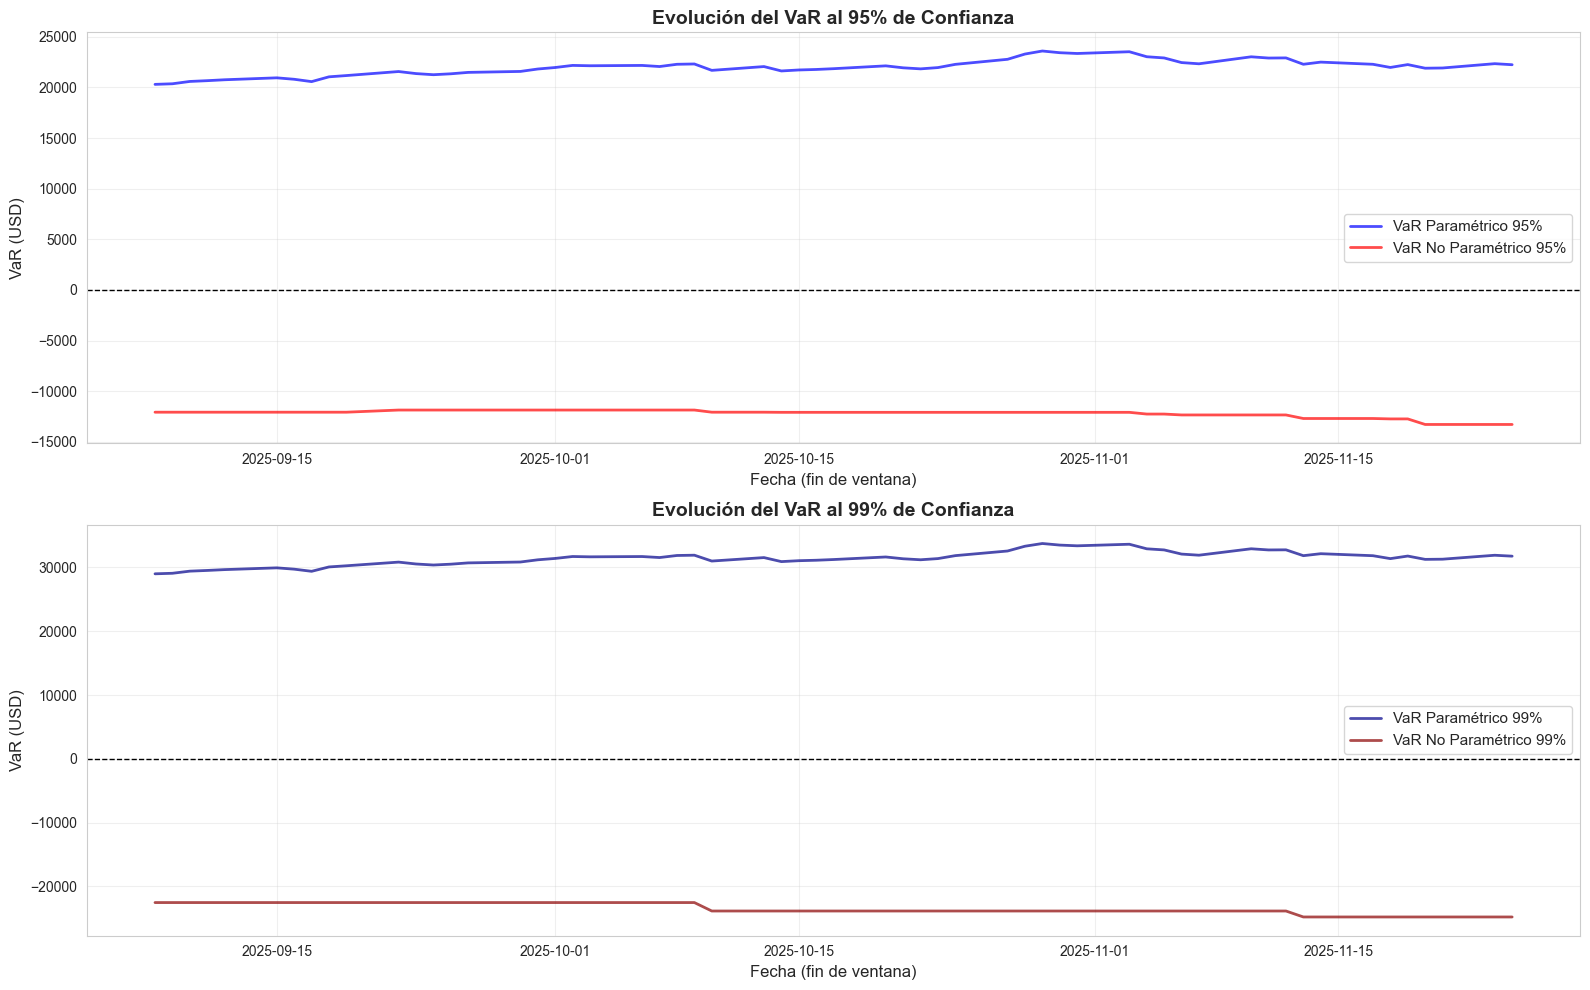

In [42]:
# Gráfico 1: VaR en USD a través del tiempo (95% y 99%)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# VaR al 95% de confianza
ax1.plot(df_resultados['fecha_fin'], df_resultados['var_param_95_usd'], 
         label='VaR Paramétrico 95%', linewidth=2, color='blue', alpha=0.7)
ax1.plot(df_resultados['fecha_fin'], df_resultados['var_noparam_95_usd'], 
         label='VaR No Paramétrico 95%', linewidth=2, color='red', alpha=0.7)
ax1.set_xlabel('Fecha (fin de ventana)', fontsize=12)
ax1.set_ylabel('VaR (USD)', fontsize=12)
ax1.set_title('Evolución del VaR al 95% de Confianza', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

# VaR al 99% de confianza
ax2.plot(df_resultados['fecha_fin'], df_resultados['var_param_99_usd'], 
         label='VaR Paramétrico 99%', linewidth=2, color='darkblue', alpha=0.7)
ax2.plot(df_resultados['fecha_fin'], df_resultados['var_noparam_99_usd'], 
         label='VaR No Paramétrico 99%', linewidth=2, color='darkred', alpha=0.7)
ax2.set_xlabel('Fecha (fin de ventana)', fontsize=12)
ax2.set_ylabel('VaR (USD)', fontsize=12)
ax2.set_title('Evolución del VaR al 99% de Confianza', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

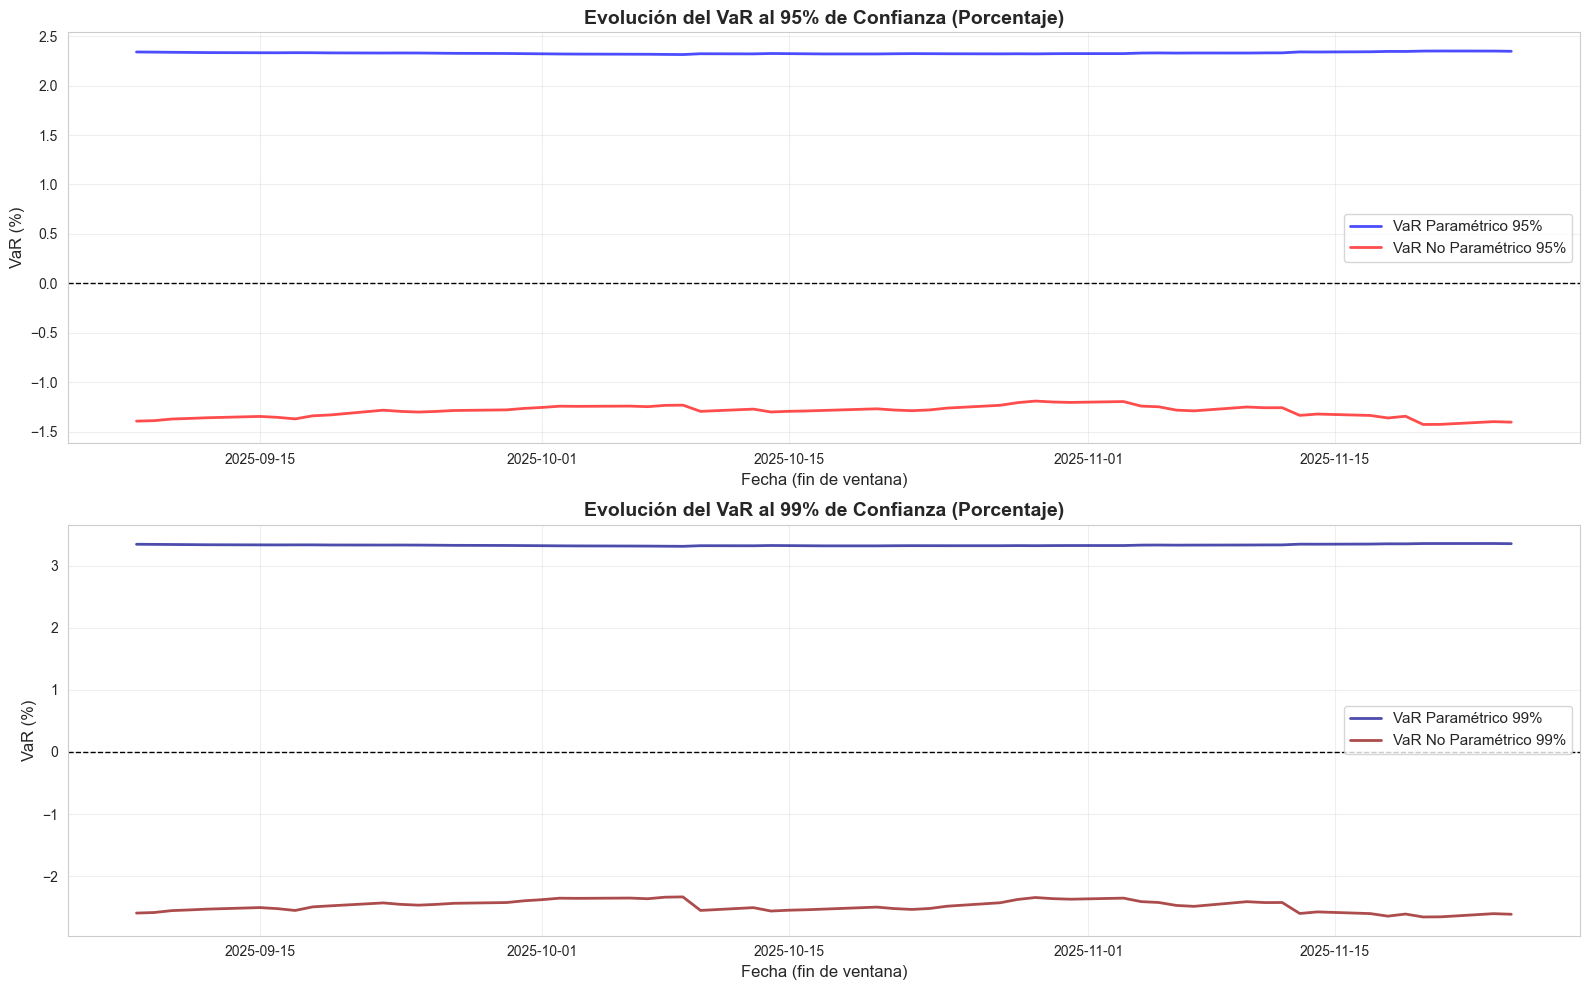

In [43]:
# Gráfico 2: VaR en Porcentaje a través del tiempo
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# VaR al 95% de confianza (%)
ax1.plot(df_resultados['fecha_fin'], df_resultados['var_param_95_pct'], 
         label='VaR Paramétrico 95%', linewidth=2, color='blue', alpha=0.7)
ax1.plot(df_resultados['fecha_fin'], df_resultados['var_noparam_95_pct'], 
         label='VaR No Paramétrico 95%', linewidth=2, color='red', alpha=0.7)
ax1.set_xlabel('Fecha (fin de ventana)', fontsize=12)
ax1.set_ylabel('VaR (%)', fontsize=12)
ax1.set_title('Evolución del VaR al 95% de Confianza (Porcentaje)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

# VaR al 99% de confianza (%)
ax2.plot(df_resultados['fecha_fin'], df_resultados['var_param_99_pct'], 
         label='VaR Paramétrico 99%', linewidth=2, color='darkblue', alpha=0.7)
ax2.plot(df_resultados['fecha_fin'], df_resultados['var_noparam_99_pct'], 
         label='VaR No Paramétrico 99%', linewidth=2, color='darkred', alpha=0.7)
ax2.set_xlabel('Fecha (fin de ventana)', fontsize=12)
ax2.set_ylabel('VaR (%)', fontsize=12)
ax2.set_title('Evolución del VaR al 99% de Confianza (Porcentaje)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

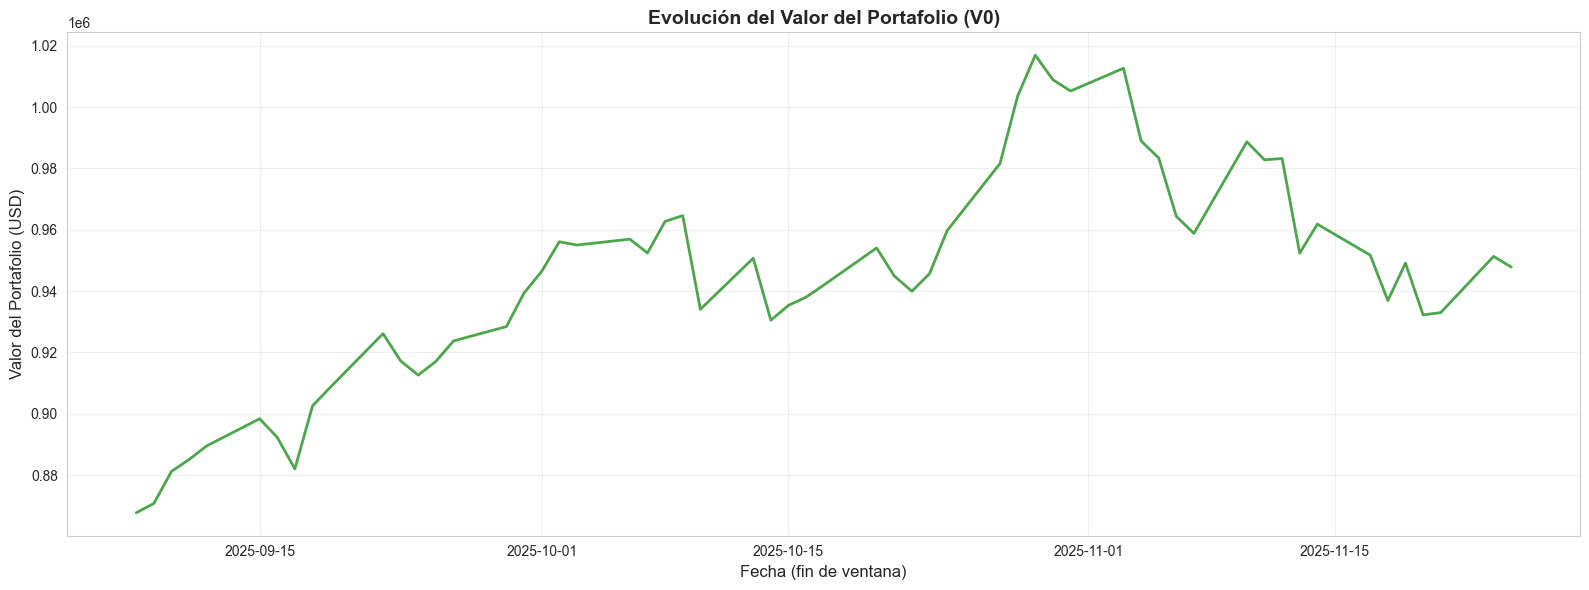

Valor inicial del portafolio: $867,738.76
Valor final del portafolio: $947,834.50
Cambio: $80,095.75 (9.23%)


In [44]:
# Gráfico 3: Evolución del Valor del Portafolio
plt.figure(figsize=(16, 6))
plt.plot(df_resultados['fecha_fin'], df_resultados['V0'], 
         linewidth=2, color='green', alpha=0.7)
plt.xlabel('Fecha (fin de ventana)', fontsize=12)
plt.ylabel('Valor del Portafolio (USD)', fontsize=12)
plt.title('Evolución del Valor del Portafolio (V0)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Valor inicial del portafolio: ${df_resultados['V0'].iloc[0]:,.2f}")
print(f"Valor final del portafolio: ${df_resultados['V0'].iloc[-1]:,.2f}")
print(f"Cambio: ${df_resultados['V0'].iloc[-1] - df_resultados['V0'].iloc[0]:,.2f} "
      f"({((df_resultados['V0'].iloc[-1] / df_resultados['V0'].iloc[0]) - 1) * 100:.2f}%)")

### 6.3 Comparación entre Métodos VaR

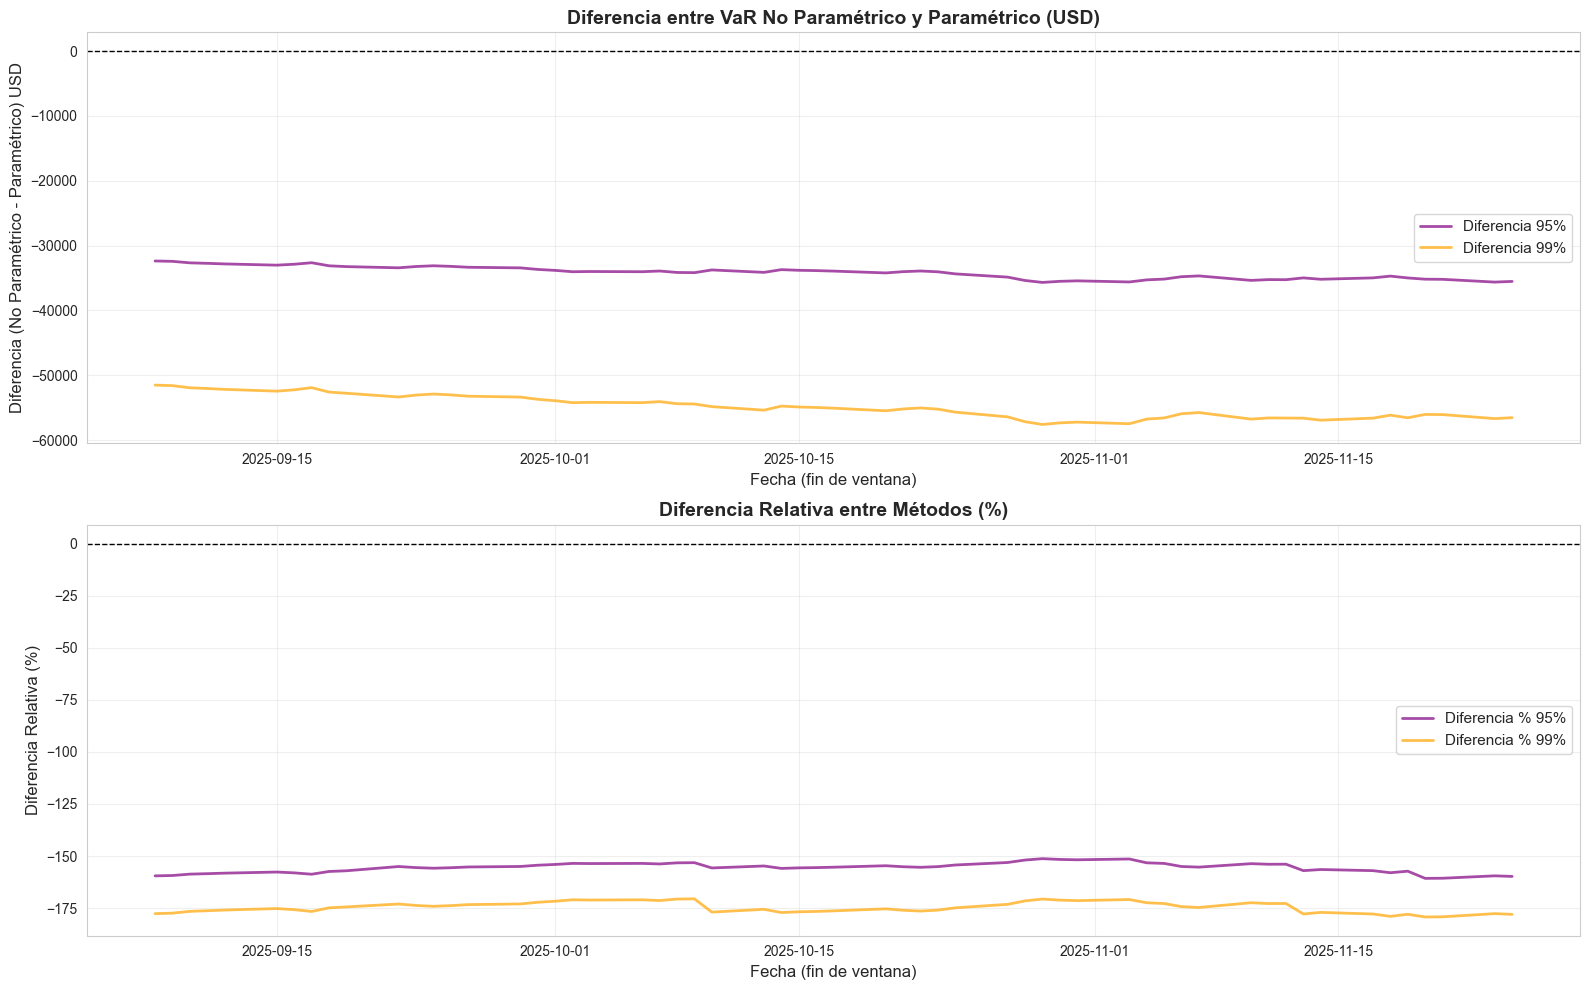


ANÁLISIS DE DIFERENCIAS ENTRE MÉTODOS

Diferencia promedio VaR 95%: $-34,184.58 (-155.58%)
Diferencia promedio VaR 99%: $-54,857.07 (-174.61%)


In [45]:
# Calcular diferencias entre métodos
df_resultados['diff_95_usd'] = df_resultados['var_noparam_95_usd'] - df_resultados['var_param_95_usd']
df_resultados['diff_99_usd'] = df_resultados['var_noparam_99_usd'] - df_resultados['var_param_99_usd']
df_resultados['diff_95_pct'] = ((df_resultados['var_noparam_95_usd'] / df_resultados['var_param_95_usd']) - 1) * 100
df_resultados['diff_99_pct'] = ((df_resultados['var_noparam_99_usd'] / df_resultados['var_param_99_usd']) - 1) * 100

# Gráfico de diferencias
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# Diferencia en USD
ax1.plot(df_resultados['fecha_fin'], df_resultados['diff_95_usd'], 
         label='Diferencia 95%', linewidth=2, color='purple', alpha=0.7)
ax1.plot(df_resultados['fecha_fin'], df_resultados['diff_99_usd'], 
         label='Diferencia 99%', linewidth=2, color='orange', alpha=0.7)
ax1.set_xlabel('Fecha (fin de ventana)', fontsize=12)
ax1.set_ylabel('Diferencia (No Paramétrico - Paramétrico) USD', fontsize=12)
ax1.set_title('Diferencia entre VaR No Paramétrico y Paramétrico (USD)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)

# Diferencia en porcentaje
ax2.plot(df_resultados['fecha_fin'], df_resultados['diff_95_pct'], 
         label='Diferencia % 95%', linewidth=2, color='purple', alpha=0.7)
ax2.plot(df_resultados['fecha_fin'], df_resultados['diff_99_pct'], 
         label='Diferencia % 99%', linewidth=2, color='orange', alpha=0.7)
ax2.set_xlabel('Fecha (fin de ventana)', fontsize=12)
ax2.set_ylabel('Diferencia Relativa (%)', fontsize=12)
ax2.set_title('Diferencia Relativa entre Métodos (%)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("ANÁLISIS DE DIFERENCIAS ENTRE MÉTODOS")
print("="*70)
print(f"\nDiferencia promedio VaR 95%: ${df_resultados['diff_95_usd'].mean():,.2f} "
      f"({df_resultados['diff_95_pct'].mean():.2f}%)")
print(f"Diferencia promedio VaR 99%: ${df_resultados['diff_99_usd'].mean():,.2f} "
      f"({df_resultados['diff_99_pct'].mean():.2f}%)")

## 7. Resultados para Fecha Específica

Mostrar los resultados de VaR para la primera ventana (23/8/2021 a 8/9/2025) y la última ventana disponible.

In [46]:
# Resultados de la primera ventana
primera_ventana = df_resultados.iloc[0]

print("="*90)
print("RESULTADOS PRIMERA VENTANA")
print(f"Período: {primera_ventana['fecha_inicio'].strftime('%d/%m/%Y')} a {primera_ventana['fecha_fin'].strftime('%d/%m/%Y')}")
print("="*90)
print(f"\nValor del Portafolio (V0): ${primera_ventana['V0']:,.2f}")
print(f"\n--- VaR al 95% de Confianza ---")
print(f"  VaR Paramétrico:")
print(f"    • En USD: ${primera_ventana['var_param_95_usd']:,.2f}")
print(f"    • En %:   {primera_ventana['var_param_95_pct']:.2f}%")
print(f"  VaR No Paramétrico:")
print(f"    • En USD: ${primera_ventana['var_noparam_95_usd']:,.2f}")
print(f"    • En %:   {primera_ventana['var_noparam_95_pct']:.2f}%")

print(f"\n--- VaR al 99% de Confianza ---")
print(f"  VaR Paramétrico:")
print(f"    • En USD: ${primera_ventana['var_param_99_usd']:,.2f}")
print(f"    • En %:   {primera_ventana['var_param_99_pct']:.2f}%")
print(f"  VaR No Paramétrico:")
print(f"    • En USD: ${primera_ventana['var_noparam_99_usd']:,.2f}")
print(f"    • En %:   {primera_ventana['var_noparam_99_pct']:.2f}%")

# Resultados de la última ventana
ultima_ventana = df_resultados.iloc[-1]

print("\n\n" + "="*90)
print("RESULTADOS ÚLTIMA VENTANA")
print(f"Período: {ultima_ventana['fecha_inicio'].strftime('%d/%m/%Y')} a {ultima_ventana['fecha_fin'].strftime('%d/%m/%Y')}")
print("="*90)
print(f"\nValor del Portafolio (V0): ${ultima_ventana['V0']:,.2f}")
print(f"\n--- VaR al 95% de Confianza ---")
print(f"  VaR Paramétrico:")
print(f"    • En USD: ${ultima_ventana['var_param_95_usd']:,.2f}")
print(f"    • En %:   {ultima_ventana['var_param_95_pct']:.2f}%")
print(f"  VaR No Paramétrico:")
print(f"    • En USD: ${ultima_ventana['var_noparam_95_usd']:,.2f}")
print(f"    • En %:   {ultima_ventana['var_noparam_95_pct']:.2f}%")

print(f"\n--- VaR al 99% de Confianza ---")
print(f"  VaR Paramétrico:")
print(f"    • En USD: ${ultima_ventana['var_param_99_usd']:,.2f}")
print(f"    • En %:   {ultima_ventana['var_param_99_pct']:.2f}%")
print(f"  VaR No Paramétrico:")
print(f"    • En USD: ${ultima_ventana['var_noparam_99_usd']:,.2f}")
print(f"    • En %:   {ultima_ventana['var_noparam_99_pct']:.2f}%")

RESULTADOS PRIMERA VENTANA
Período: 23/08/2021 a 08/09/2025

Valor del Portafolio (V0): $867,738.76

--- VaR al 95% de Confianza ---
  VaR Paramétrico:
    • En USD: $20,302.89
    • En %:   2.34%
  VaR No Paramétrico:
    • En USD: $-12,080.56
    • En %:   -1.39%

--- VaR al 99% de Confianza ---
  VaR Paramétrico:
    • En USD: $29,008.21
    • En %:   3.34%
  VaR No Paramétrico:
    • En USD: $-22,518.51
    • En %:   -2.60%


RESULTADOS ÚLTIMA VENTANA
Período: 10/11/2021 a 25/11/2025

Valor del Portafolio (V0): $947,834.50

--- VaR al 95% de Confianza ---
  VaR Paramétrico:
    • En USD: $22,242.76
    • En %:   2.35%
  VaR No Paramétrico:
    • En USD: $-13,293.37
    • En %:   -1.40%

--- VaR al 99% de Confianza ---
  VaR Paramétrico:
    • En USD: $31,774.19
    • En %:   3.35%
  VaR No Paramétrico:
    • En USD: $-24,776.98
    • En %:   -2.61%


## 8. Exportar Resultados

Guardar todos los resultados en un archivo CSV para análisis posterior.

In [47]:
# Crear DataFrame limpio para exportar
df_export = df_resultados[[
    'fecha_inicio', 'fecha_fin', 'V0',
    'var_param_95_usd', 'var_param_95_pct',
    'var_param_99_usd', 'var_param_99_pct',
    'var_noparam_95_usd', 'var_noparam_95_pct',
    'var_noparam_99_usd', 'var_noparam_99_pct',
    'media_rendimiento', 'std_rendimiento'
]].copy()

# Renombrar columnas para mejor claridad
df_export.columns = [
    'Fecha_Inicio', 'Fecha_Fin', 'Valor_Portafolio_USD',
    'VaR_Param_95%_USD', 'VaR_Param_95%_Pct',
    'VaR_Param_99%_USD', 'VaR_Param_99%_Pct',
    'VaR_NoPar_95%_USD', 'VaR_NoPar_95%_Pct',
    'VaR_NoPar_99%_USD', 'VaR_NoPar_99%_Pct',
    'Media_Rendimiento', 'Std_Rendimiento'
]

# Guardar a CSV
archivo_salida = 'resultados_var_rolling_1000dias.csv'
df_export.to_csv(archivo_salida, index=False)

print(f"✓ Resultados exportados exitosamente a: {archivo_salida}")
print(f"\nTotal de registros exportados: {len(df_export)}")
print(f"Columnas: {', '.join(df_export.columns)}")

✓ Resultados exportados exitosamente a: resultados_var_rolling_1000dias.csv

Total de registros exportados: 57
Columnas: Fecha_Inicio, Fecha_Fin, Valor_Portafolio_USD, VaR_Param_95%_USD, VaR_Param_95%_Pct, VaR_Param_99%_USD, VaR_Param_99%_Pct, VaR_NoPar_95%_USD, VaR_NoPar_95%_Pct, VaR_NoPar_99%_USD, VaR_NoPar_99%_Pct, Media_Rendimiento, Std_Rendimiento


## 9. Interpretación y Conclusiones

### Interpretación de Resultados

**VaR Paramétrico:**
- Asume que los rendimientos siguen una distribución normal
- Utiliza media y desviación estándar de los rendimientos históricos
- Más simple y rápido de calcular
- Puede subestimar riesgos extremos si la distribución real tiene colas pesadas

**VaR No Paramétrico (Histórico):**
- No asume ninguna distribución específica
- Utiliza directamente los percentiles del P&L histórico
- Captura mejor eventos extremos y asimetrías
- Más robusto cuando los datos no siguen una distribución normal

**Niveles de Confianza:**
- **95% de confianza (5% VaR):** Hay un 5% de probabilidad de que las pérdidas excedan este valor
- **99% de confianza (1% VaR):** Hay un 1% de probabilidad de que las pérdidas excedan este valor

### Recomendaciones

1. **Monitoreo continuo:** El VaR debe calcularse regularmente para reflejar cambios en la volatilidad del mercado
2. **Uso de ambos métodos:** Comparar ambos métodos ayuda a entender mejor el perfil de riesgo
3. **Backtesting:** Verificar que las pérdidas reales excedan el VaR en la frecuencia esperada
4. **Límites de riesgo:** Establecer límites basados en el VaR para la gestión del portafolio

# Reporte Final

Equipo 3

- Arturo Hernández Pereztagle			A00838056
- José Eduardo López Arzamendi			A00836314
- Jose Miguel Ruiz de la Garza			A01722268
- Juan Marco Castro Trinidad			A01742821

## Preparación de datos

In [48]:
# Convierte el excel a csv
import pandas as pd

def excel_a_csv(ruta_excel, ruta_csv):
    # Lee el archivo Excel
    df = pd.read_excel(ruta_excel)
    
    # Guarda el DataFrame como un archivo CSV
    df.to_csv(ruta_csv, index=False)

if __name__ == "__main__":
    ruta_excel = "precios_historicos.xlsx"
    ruta_csv = "precios_historicos.csv"
    excel_a_csv(ruta_excel, ruta_csv)
    print(f"Archivo convertido de {ruta_excel} a {ruta_csv}")

Archivo convertido de precios_historicos.xlsx a precios_historicos.csv


## Exploración de datos

## Analisis